# Implementing MLP for makemore bigram

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read ain all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
#build vocabulary of the characters and mappings to /from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [13]:
# dataset for the neural network
block_size = 3 # context length : how many characters do we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->' , itos[ix])
        context = context[1:]+[ix] # crop and append
        #print(f'{context = }')

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [14]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [17]:
Y # labels

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Build Neural Network

In [18]:
# first lets build the embedding lookup table C
# we have 27 characters and need to cramp them to 2 D space => each character has 2 embedding values
C = torch.randn((27,2))

In [22]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [29]:
emb = C[X] # each of the 32X3 words that we have in input X are converted into embeddings
emb.shape

torch.Size([32, 3, 2])

In [30]:
# Now are passing 2D embedding for each of 3 input characters so we will send 6 weights to the next layer
# lets say we 100 neurons in this layer
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [33]:
# we need to concatinate the inputs to the layer
# all inputs from node 0, node 1, node 2 : because we have only 3 nodes. Concatinate column wise so dim = 1

torch.cat([emb[:,0,:] , emb[:,1,:] , emb[:,2,:]], dim = 1).shape

# this is not compatible if we change the context window so we will use torch.unbind which takes the tensor and the dimension on which we need to reducce

torch.Size([32, 6])

In [35]:
torch.cat(torch.unbind(emb,1), 1).shape

torch.Size([32, 6])

In [36]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [37]:
# we can re represent this vector into different dimension vectors using view()
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [39]:
a.view(3, 3, 2) # the sequence of the values is preserved. We are just viewing the vector differently

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [40]:
emb.shape

torch.Size([32, 3, 2])

In [42]:
emb.view(32,6) # this gives the same result as the torch.cat(torch.unbind(....)) we did earlier

tensor([[-2.5731, -0.1225, -2.5731, -0.1225, -2.5731, -0.1225],
        [-2.5731, -0.1225, -2.5731, -0.1225, -1.2714, -0.3607],
        [-2.5731, -0.1225, -1.2714, -0.3607,  1.5447, -0.9159],
        [-1.2714, -0.3607,  1.5447, -0.9159,  1.5447, -0.9159],
        [ 1.5447, -0.9159,  1.5447, -0.9159,  1.0643,  1.2094],
        [-2.5731, -0.1225, -2.5731, -0.1225, -2.5731, -0.1225],
        [-2.5731, -0.1225, -2.5731, -0.1225, -1.2813, -0.3282],
        [-2.5731, -0.1225, -1.2813, -0.3282,  0.2500, -1.1538],
        [-1.2813, -0.3282,  0.2500, -1.1538,  0.2674, -0.2264],
        [ 0.2500, -1.1538,  0.2674, -0.2264,  0.6190,  0.2860],
        [ 0.2674, -0.2264,  0.6190,  0.2860,  0.2674, -0.2264],
        [ 0.6190,  0.2860,  0.2674, -0.2264,  1.0643,  1.2094],
        [-2.5731, -0.1225, -2.5731, -0.1225, -2.5731, -0.1225],
        [-2.5731, -0.1225, -2.5731, -0.1225,  1.0643,  1.2094],
        [-2.5731, -0.1225,  1.0643,  1.2094,  0.6190,  0.2860],
        [ 1.0643,  1.2094,  0.6190,  0.2

In [46]:
h = emb.view(32,6) @ W1 + b1 # Instead of hardcoding the number of inputs lets just put -1 for rows so 
# pytorch will figure out what the dimension should be

In [47]:
h.shape

torch.Size([32, 100])

In [48]:
h = emb.view(-1,6) @ W1 + b1 # here we passed -1 to view . Because we fixed 6, pytorch will look at emb and decide 32 is the no. of rows

In [49]:
h.shape

torch.Size([32, 100])

In [50]:
# Now that we know how to do the emb@W +b , will pass these values to the activation function. We are using tanh
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [51]:
h.shape

torch.Size([32, 100])

In [52]:
# Now creating the final layer 
W2 = torch.randn((100,27)) # we have 27set vocabulary
b2 = torch.rand(27)

In [53]:
logits = h @ W2 + b2

In [54]:
logits.shape

torch.Size([32, 27])

In [55]:
counts = logits.exp()

In [56]:
prob = counts/counts.sum(1, keepdims = True)

In [57]:
prob.shape

torch.Size([32, 27])

In [60]:
prob[0].sum() # every row should sum to 1 => normalized values

tensor(1.)

In [61]:
# Now we take a row from the prob and see probability assigned to each correct character in Y 
torch.arange(32) # uing thos as index to Y

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [65]:
prob[torch.arange(32), Y] # probability of ech correct chacter in Y

tensor([9.2294e-05, 2.5316e-09, 1.0386e-12, 1.3484e-10, 1.9402e-04, 3.1426e-02,
        6.6006e-01, 2.0568e-10, 6.0274e-12, 7.9194e-08, 4.0202e-07, 1.1059e-04,
        2.0397e-04, 1.7626e-08, 5.5746e-18, 2.5301e-08, 1.6499e-09, 2.1608e-05,
        3.9714e-16, 3.8710e-06, 1.2731e-08, 3.7525e-06, 9.9312e-01, 3.7951e-04,
        2.9026e-07, 1.0320e-03, 1.2447e-04, 1.4593e-05, 5.9402e-14, 5.3445e-09,
        1.4784e-06, 3.6392e-04])

In [66]:
# idially the probabilities above should be close to 1. We need to train the network

In [67]:
loss = -prob[torch.arange(32), Y].log().mean() # -ve log likelyhood loss

In [69]:
loss # need to minimize the loss

tensor(15.4398)

In [71]:
# lets bring everything together

X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [72]:
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27,2) , generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27 , generator = g)
parameters = [C , W1, b1, W2, b2]

In [74]:
# number of parameters in total
sum(p.nelement() for p in parameters)

3481

In [75]:
emb = C[X] # for each input convert into embedding values of 2D .we are suing only 2 dimensions.
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1, keepdims = True)
loss = -prob[torch.arange(32) , Y].log().mean()
loss

tensor(17.7697)

In [79]:
# we can further simplify the loss calculation . We can use cross_entropy which calulates counts,probs and then loss

# set the grad rewuirement to true for every parameter
for p in parameters:
    p.requires_grad = True
    
for _ in range(1000): # epochs = 10
    # Forward Pass
    
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.25609779357910156


In [133]:
# for now we were only using 5 words => 32 inputs

# lets read in the full datasets
# dataset for the neural network
block_size = 3 # context length : how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    #print(w)
    context = [0]*block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->' , itos[ix])
        context = context[1:]+[ix] # crop and append
        #print(f'{context = }')

X = torch.tensor(X)
Y = torch.tensor(Y)

In [134]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [143]:
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27,2) , generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27 , generator = g)
parameters = [C , W1, b1, W2, b2]

In [144]:
# number of parameters in total
sum(p.nelement() for p in parameters)

3481

In [85]:
# set the grad rewuirement to true for every parameter
for p in parameters:
    p.requires_grad = True
    
for _ in range(10): # epochs = 10
    # Forward Pass
    
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

11.05185604095459


In [104]:
# because we are taking aboubt 22K inputs it is taking lot of time. So what we can do is we can train the network int batches. 

# set the grad rewuirement to true for every parameter
for p in parameters:
    p.requires_grad = True
    
for _ in range(100): # epochs = 10
    # construct mini batches
    ix = torch.randint(0,X.shape[0], (32,)) # mini batch size set to 32
    # Forward Pass
    
    emb = C[X[ix]] # index to only 32 inputs (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

4.229219436645508


In [105]:
# because we are using mini batches the quality of gradient is not reliable
# so it is better to get approximate gradient and take more steps than calculate the exact gradient and take fewer steps

In [113]:
# Also we just randomly took learning rate as -0.1 . But we need to find out good learning rate
# we need to keep trying different learning rates for that we do

lre = torch.linspace(-3,0,1000) # with step size of 1000, generate numbers between -3 and 0
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [114]:
# Now instead of using fixed learning rate lets try out different

# keeping track of learning rate used and the corressponding loss that occurred
lri = []
lossi = []

for p in parameters:
    p.requires_grad = True
    
for i in range(1000): # epochs = 10
    # construct mini batches
    ix = torch.randint(0,X.shape[0], (32,)) # mini batch size set to 32
    # Forward Pass
    
    emb = C[X[ix]] # index to only 32 inputs (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

7.282004356384277


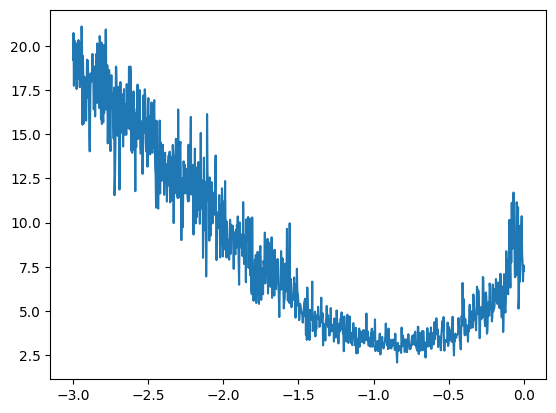

In [115]:
plt.plot(lri, lossi)

In [147]:
# we can see the good loss is at around -1.0
# good learnign rate is 10 ** -1 => 0.1

lri = []
lossi = []

for p in parameters:
    p.requires_grad = True
    
for i in range(10000): # epochs = 10
    # construct mini batches
    ix = torch.randint(0,X.shape[0], (32,)) # mini batch size set to 32
    # Forward Pass
    
    emb = C[X[ix]] # index to only 32 inputs (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    lr = 0.1  # later after few runs if we see we are at better loss we start doing learning rate decay that is here we reduce it to 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

#print(loss.item())

In [148]:
print(loss.item())

2.1691102981567383


In [122]:
# keep runing the above 2 cells for more iterations 

In [149]:
# we got better results
# bute lets divide the input data to test , validation and train sets so we dont overfit the model

In [150]:
# lets split the data 

#build dataset

def build_dataset(words):
    block_size = 3 # context length : how many characters do we take to predict the next one?
    X, Y = [], []
    
    for w in words:
        #print(w)
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->' , itos[ix])
            context = context[1:]+[ix] # crop and append
            #print(f'{context = }')
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = (int)(0.8 * len(words)) # 80% of data to train dataset
n2 = (int)(0.9 * len(words)) # 10% to validation. We take words from n1 to n2

Xtr , Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [161]:
g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((27,2) , generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27 , generator = g)
parameters = [C , W1, b1, W2, b2]

In [162]:
# Training the neural network

lri = []
lossi = []

for p in parameters:
    p.requires_grad = True
    
for i in range(10000): # epochs = 10
    # construct mini batches
    ix = torch.randint(0,Xtr.shape[0], (32,)) # mini batch size set to 32
    # Forward Pass
    
    emb = C[Xtr[ix]] # index to only 32 inputs (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    lr = 0.1  # later after few runs if we see we are at better loss we start doing learning rate decay that is here we reduce it to 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

#print(loss.item())

In [163]:
print(loss.item())

2.247884750366211


In [164]:
# lets evaluate the results on validation set
emb = C[Xdev] # index to only 32 inputs (32,3,2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.482536554336548


In [165]:
# lets try to increase the size of the neural network, by increase the number nodes in the hidden layers to 300 from 100

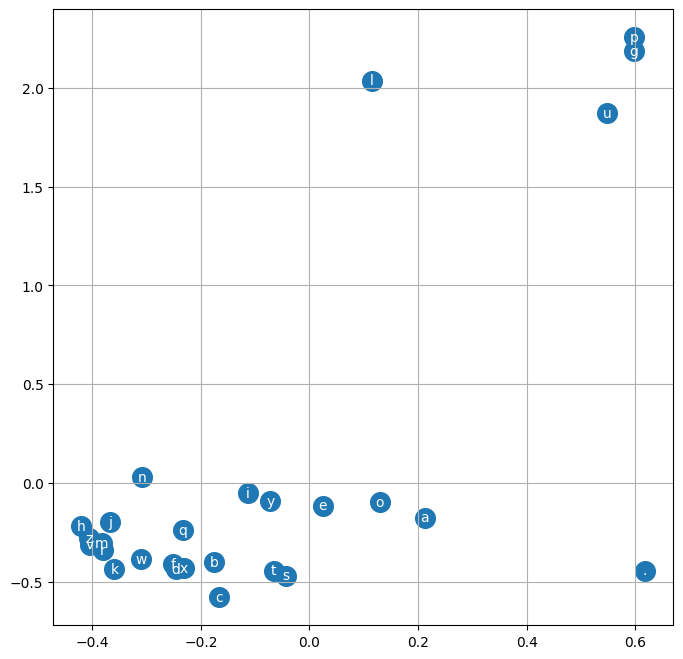

In [166]:
# for now we try to plot the embeddings to see how they are grouped 
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data , s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = 'center' , va = 'center', color = 'white')
plt.grid('minor')

In [217]:
# We can try to improve the loss value by chnaging the embedding layer. Instead of having 2D embeddings we can try 10 dimensional embedding

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [218]:
sum(p.nelement() for p in parameters)

11897

In [219]:
for p in parameters:
    p.requires_grad = True

In [220]:
lre = torch.linspace(-3,0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [221]:
for i in range(50000): # epochs = 10
    # construct mini batches
    ix = torch.randint(0,Xtr.shape[0], (32,)) # mini batch size set to 32
    # Forward Pass
    
    emb = C[Xtr[ix]] # index to only 32 inputs (32,3,2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    lr = 0.1  # later after few runs if we see we are at better loss we start doing learning rate decay that is here we reduce it to 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

    stepi.append(i)
    lossi.append(loss.log10().item()) # using log10 we can squash the loss values and when we plot it looks better

#print(loss.item())

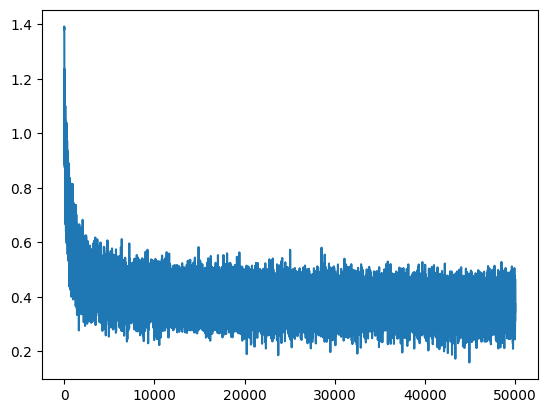

In [222]:
plt.plot(stepi, lossi)

In [223]:
print(loss.item()) # loss on training set

2.217449903488159


In [225]:
# loss on dev set

# lets evaluate the results on validation set
emb = C[Xdev] # index to only 32 inputs (32,3,2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.349750518798828


In [229]:
# decrease the learning rate and trai for another 50k iterations
for i in range(50000): # epochs = 10
    # construct mini batches
    ix = torch.randint(0,Xtr.shape[0], (32,)) # mini batch size set to 32
    # Forward Pass
    
    emb = C[Xtr[ix]] # index to only 32 inputs (32,3,2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update the gradients of p
    lr = 0.01  # later after few runs if we see we are at better loss we start doing learning rate decay that is here we reduce it to 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())

    stepi.append(i)
    lossi.append(loss.log10().item()) # using log10 we can squash the loss values and when we plot it looks better


In [230]:
print(loss.item()) # loss on training set

2.1630513668060303


In [231]:
# validation performance

# lets evaluate the results on validation set
emb = C[Xdev] # index to only 32 inputs (32,3,2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.197722911834717


In [232]:
# loss on train set has increased bu tloss on the validation set has improved
# lets try to improve validation loss
# we can try to increase the context window or learning rate decay or improve the embeddign dimensions
# the best training set loss we have seen is 1.9094375896453857
# validation set loss = 2.187696695327759
# because the training set loss and validation set loss has high variation , we can say the model is overfitting on the training set

# after trying for multiple rounds the the clossest of loss values we were able to achive were  test loss : 2.167135772705078, validation loss :2.198936939239502 

In [234]:
# lets try to use the model to generate the names

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(10):
    out = []
    context = [0]*block_size # initialize with ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:]+ [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))
            

carmah.
ambrilli.
kimri.
reviyah.
cassy.
jazonte.
delynn.
jareen.
ner.
kia.
